In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [7]:
dataset = read_csv("60min_Seg.csv",
                   parse_dates={'ST' : ['StartTime15']},
                   infer_datetime_format=True, 
                   index_col= 1,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values


In [8]:
dataset.head(4)

,ST,StartTime,StartTimeConv,EndTime,Speed,Wind Direction,Wind Speed
SegmentId,,,,,,,
226255131,44522.333333333,11/22/2021 8:00,44522.33333,11/22/2021 9:00,94.521739,237,6.1
226255131,44522.291666666,11/22/2021 7:00,44522.29167,11/22/2021 8:00,96.733333,255,5.9
226255131,44522.25,11/22/2021 6:00,44522.25000,11/22/2021 7:00,100.383333,248,5.3
226255131,44522.208333333,11/22/2021 5:00,44522.20833,11/22/2021 6:00,94.050000,271,4.6


In [9]:
dataset.drop(columns  = [ 'EndTime','StartTime','StartTimeConv'], inplace = True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [10]:
dataset.head(4)

,ST,Speed,Wind Direction,Wind Speed
SegmentId,,,,
226255131,44522.333333333,94.521739,237,6.1
226255131,44522.291666666,96.733333,255,5.9
226255131,44522.25,100.383333,248,5.3
226255131,44522.208333333,94.050000,271,4.6


In [17]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 5))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3
0,5.000000,3.430484,3.291667,1.540404
1,4.999786,3.517021,3.541667,1.489899
2,4.999542,3.659841,3.444444,1.338384
3,4.999298,3.412025,3.763889,1.161616


In [18]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [22]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,3)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)','var4(t-1)', 'var5(t-1)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
id                                                       
1    5.000000   3.430484   3.291667   1.540404   1.489899
2    4.999786   3.517021   3.541667   1.489899   1.338384
3    4.999542   3.659841   3.444444   1.338384   1.161616
4    4.999298   3.412025   3.763889   1.161616   1.313131


In [23]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.75)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [24]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14995, 1, 4) (14995,) (6426, 1, 4) (6426,)


In [25]:
model_gru = Sequential()
model_gru.add(GRU(265, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=60, return_sequences=True))
model_gru.add(GRU(units=60))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 265)            215445    
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 60)             58860     
_________________________________________________________________
gru_2 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 296,326
Trainable params: 296,326
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=80,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/80
235/235 [==============================] - 17s 10ms/step - loss: 0.5103 - val_loss: 0.2032
Epoch 2/80
235/235 [==============================] - 1s 5ms/step - loss: 0.2411 - val_loss: 0.1981
Epoch 3/80
235/235 [==============================] - 1s 5ms/step - loss: 0.2245 - val_loss: 0.2054
Epoch 4/80
235/235 [==============================] - 1s 5ms/step - loss: 0.2210 - val_loss: 0.1991
Epoch 5/80
235/235 [==============================] - 1s 4ms/step - loss: 0.2265 - val_loss: 0.2006
Epoch 6/80
235/235 [==============================] - 1s 4ms/step - loss: 0.2270 - val_loss: 0.2019
Epoch 7/80
235/235 [==============================] - 1s 4ms/step - loss: 0.2287 - val_loss: 0.2276
Epoch 8/80
235/235 [==============================] - 1s 4ms/step - loss: 0.2278 - val_loss: 0.2350
Epoch 9/80
235/235 [==============================] - 1s 5ms/step - loss: 0.2319 - val_loss: 0.2348
Epoch 10/80
235/235 [==============================] - 1s 5ms/step - loss: 0.2413 - val_loss: 0.23

In [27]:
pred_y =  model_gru.predict(test_X)

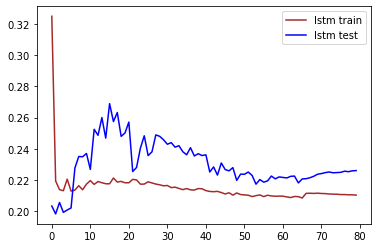

In [28]:
pyplot.plot(gru_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [30]:
test_y.reshape(6426,1)

array([[3.106061 ],
       [2.9797983],
       [3.0303032],
       ...,
       [2.070707 ],
       [2.1212122],
       [1.2878789]], dtype=float32)

In [31]:
pred_y

array([[3.1370506],
       [3.0838635],
       [2.9581158],
       ...,
       [2.0083692],
       [2.0721092],
       [2.1276996]], dtype=float32)

0.1005556
0.8031119390990878
0.3171050279257794
0.225926


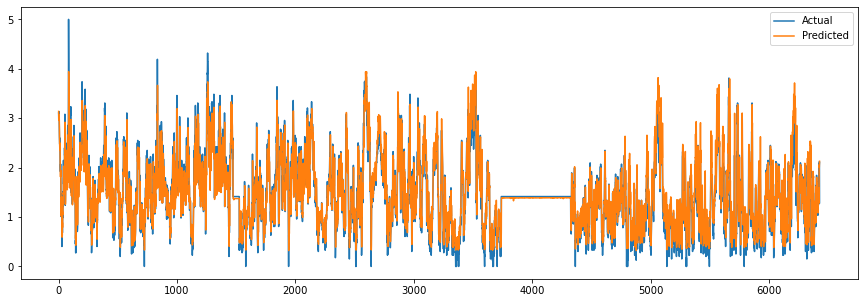

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

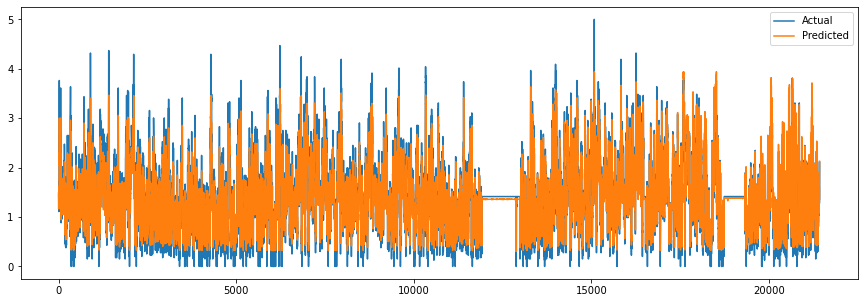

In [33]:
#visualization over full data
tra = np.concatenate([train_X,test_X])
tes = np.concatenate([train_y,test_y])
fp = model_gru.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

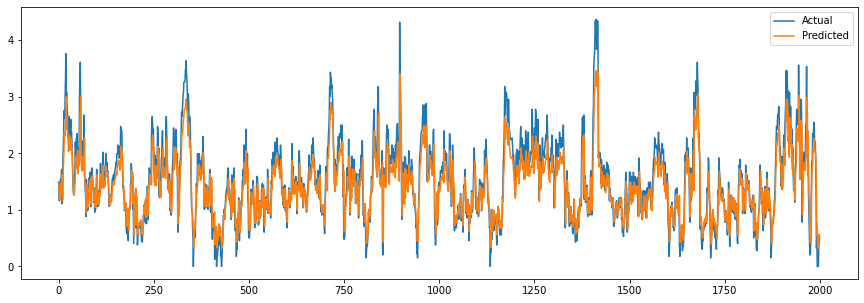

In [34]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()